# Adversarial example using pytorch

In this example, we redo the [adversarial example](https://gurobi-optimization-ml2gurobi.readthedocs-hosted.com/en/latest/examples/adversarial_mnist.html) of the documentation but use pytorch for training the neural network.

We don't detail the optimization model here. Please refer to the example in the documentation.

This example requires the additional packages:
 - [torch](https://pytorch.org/)
 - [torchvision](https://pytorch.org/)
 - [matplotlib](https://matplotlib.org/)
 - [skorch](https://skorch.readthedocs.io/en/stable/)

 The latter package is a wrapper for giving to pytorch a Scikit-Learn like interface.

## Import the necessary packages and load data

We import all the package we need for this example.
We fetch the MINST data set using sklearn's functionalities.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms


import gurobipy as gp

from gurobi_ml import add_predictor_constr

from base_trainer import trainer

In [2]:
max_epochs = 2
batch_size=128
lr =0.1

In [3]:
# Get MNIST digit recognition data set
mnist_train = torchvision.datasets.MNIST(root="../Dataset/MNIST", train=True,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]), download=True)

mnist_test = torchvision.datasets.MNIST(root="../Dataset/MNIST", train=False,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]), download=True)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,
                                           shuffle=True,)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,
                                           shuffle=False)


## Construct and train the neural network

We construct a sequential neural network with 2 hidden layers of 50 neurons.
To train it, we use `skorch` that provides an interface similar to `scikit-learn`.

In [4]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    torch.nn.Softmax(1),
)

In [5]:
clf = trainer(
    nn_model,
    max_epochs=max_epochs,
    lr=lr
)

clf.fit(train_loader)

ffgf
epoch 1/2, loss = -0.1022
epoch 1/2, loss = -0.1046
epoch 1/2, loss = -0.1008
epoch 1/2, loss = -0.1004
epoch 1/2, loss = -0.1026
epoch 2/2, loss = -0.1022
epoch 2/2, loss = -0.1009
epoch 2/2, loss = -0.1037
epoch 2/2, loss = -0.1022
epoch 2/2, loss = -0.1012


In [6]:
nn_model[0].weight.device

device(type='cpu')

In [7]:
print(f"Training score: {clf.score(train_loader):.4}")
print(f"Validation set score: {clf.score(test_loader):.4}")

Training score: 0.01333
Validation set score: 0.0


In [ ]:
nn_regression = torch.nn.Sequential(*nn_model[:-1]).cpu()
nn_regression

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=10, bias=True)
)

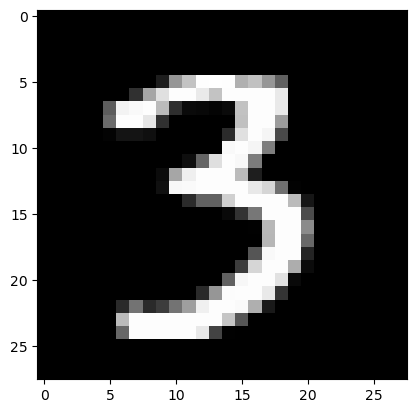

In [ ]:
imageno = 10000
image = mnist_train.data[imageno, :]
plt.imshow(image, cmap="gray")

In [ ]:
flat_img = image.reshape(-1,28*28).type(torch.float32).squeeze(0)
ex_prob = nn_regression.forward(flat_img)
sorted_labels = torch.argsort(ex_prob)
right_label = sorted_labels[-1]
wrong_label = sorted_labels[-2]

In [ ]:
image.shape

(784,)

In [ ]:
ex_prob.detach().numpy().shape

(10,)

In [ ]:
image = flat_img.numpy()  # We need numpy converted image

m = gp.Model()
delta = 5

x = m.addMVar(image.shape, lb=0.0, ub=1.0, name="x")
y = m.addMVar(ex_prob.detach().numpy().shape, lb=-gp.GRB.INFINITY, name="y")

abs_diff = m.addMVar(image.shape, lb=0, ub=1, name="abs_diff")

m.setObjective(y[wrong_label] - y[right_label], gp.GRB.MAXIMIZE)

# Bound on the distance to example in norm-1
m.addConstr(abs_diff >= x - image)
m.addConstr(abs_diff >= -x + image)
m.addConstr(abs_diff.sum() <= delta)

pred_constr = add_predictor_constr(m, nn_regression, x, y)

pred_constr.print_stats()

Restricted license - for non-production use only - expires 2024-10-28
Model for sequential:
200 variables
110 constraints
100 general constraints
Input has shape (1, 784)
Output has shape (1, 10)

--------------------------------------------------------------------------------
Layer           Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
linear_0             (1, 50)           50           50            0            0

relu_1               (1, 50)           50            0            0           50

linear_2             (1, 50)           50           50            0            0

relu_3               (1, 50)           50            0            0           50

linear_4             (1, 10)            0           10            0            0

--------------------------------------------------------------------------------


In [ ]:
m.Params.BestBdStop = 0.0
m.Params.BestObjStop = 0.0
m.optimize()

Set parameter BestBdStop to value 0
Set parameter BestObjStop to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD EPYC 7402 24-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 48 physical cores, 96 logical processors, using up to 32 threads

Optimize a model with 1679 rows, 1778 columns and 46230 nonzeros
Model fingerprint: 0x92e40b5a
Model has 100 general constraints
Variable types: 1778 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-07, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 3e+02]
Presolve removed 794 rows and 10 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 96 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -


In [ ]:
if m.ObjVal > 0.0:
    plt.imshow(x.X.reshape((28, 28)), cmap="gray")
    x_input = torch.tensor(x.X.reshape(1, -1), dtype=torch.float32)
    label = torch.argmax(nn_model.forward(x_input))
    print(f"Solution is classified as {label}")
else:
    print("No counter example exists in neighborhood.")

No counter example exists in neighborhood.


copyright © 2022 Gurobi Optimization, LLC